# Selecting hyperparameters

CorrAdjust uses two hyperparameters:

1. Number of PCs to consider during the confounder selection (primarily impacts computational complexity).
1. Fraction of all feature pairs that are labeled as "highly correlated".

## Number of PCs

The main goal of CorrAdjust is to find a subset of confounder PCs to regress out from the data.
The search of this subset could be limited to the first `n_PCs` to dramatically
improve time requirements, as the total number of algorithm iterations is proportional to `n_PCs ** 2`.

The default method to determine number of PCs is to plot cumulative % variance explained by each PC, and then automatically select the "knee" point. Any other value that confidently falls in the "plateau" zone of the cumulative plot will work as well. Alternatively, you can use `num.sv` function from the `sva` package in R to estimate the number of significant PCs.

2025-02-28 20:00:51.535175 | Loading Canonical Pathways reference collection...
2025-02-28 20:00:52.866908 | Loading Gene Ontology reference collection...
2025-02-28 20:00:54.972667 | Computing PCA...


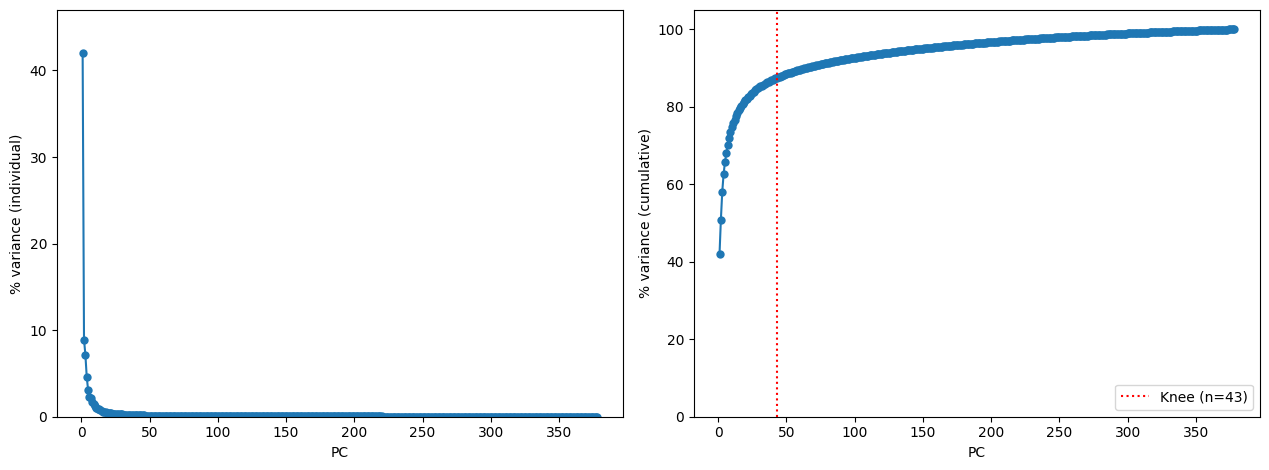

In [13]:
# Re-initialize the model
model = CorrAdjust(
    df_feature_ann,
    ref_feature_colls,
    "out_data/GTEx_Whole_Blood"
)

PCs, PC_coefs, n_PCs_knee, df_data_train_wins_cent = (
    model.fit_PCA(df_data_train, plot_var=True)
)
# If needed, you can access the sklearn's PCA object through model.PCA_model

The above code produces file `PCA_var.png`. Selecting `n_PCs = 43` (auto-detected) looks reasonable, but might be as well reduced to make the computations faster.

## Fraction of highly ranked feature pairs

During the `fit` call, CorrAdjust optimizes enrichment of correlations with respect to the provided reference set.
The computation is done with a subset of most highly ranked feature pairs, and their number is set by `high_corr_frac` parameter in a configuration dict.
From our experiments, the value of 0.01 works well in mRNA-mRNA settings, and 0.05 works well in the miRNA-mRNA case (see CorrAdjust paper).

The value of `high_corr_frac` is associated with the following trade-off:

- Too high value of `high_corr_frac` will result in consideration of many non-significant correlations, thus diluting the enrichment signal.
- Too low value of `high_corr_frac` will result in too few feature pairs being analyzed, thus reducing statistical power of the enrichment analysis.

You might consider decreasing `high_corr_frac` if CorrAdjust shows very little or no improvement in score compared to the baseline during the `fit` call.
Plotting correlation distribution plots for the raw (uncorrected) correlations is a good starting point.

2025-02-28 20:00:57.335620 | Computing raw correlations for all_samp...


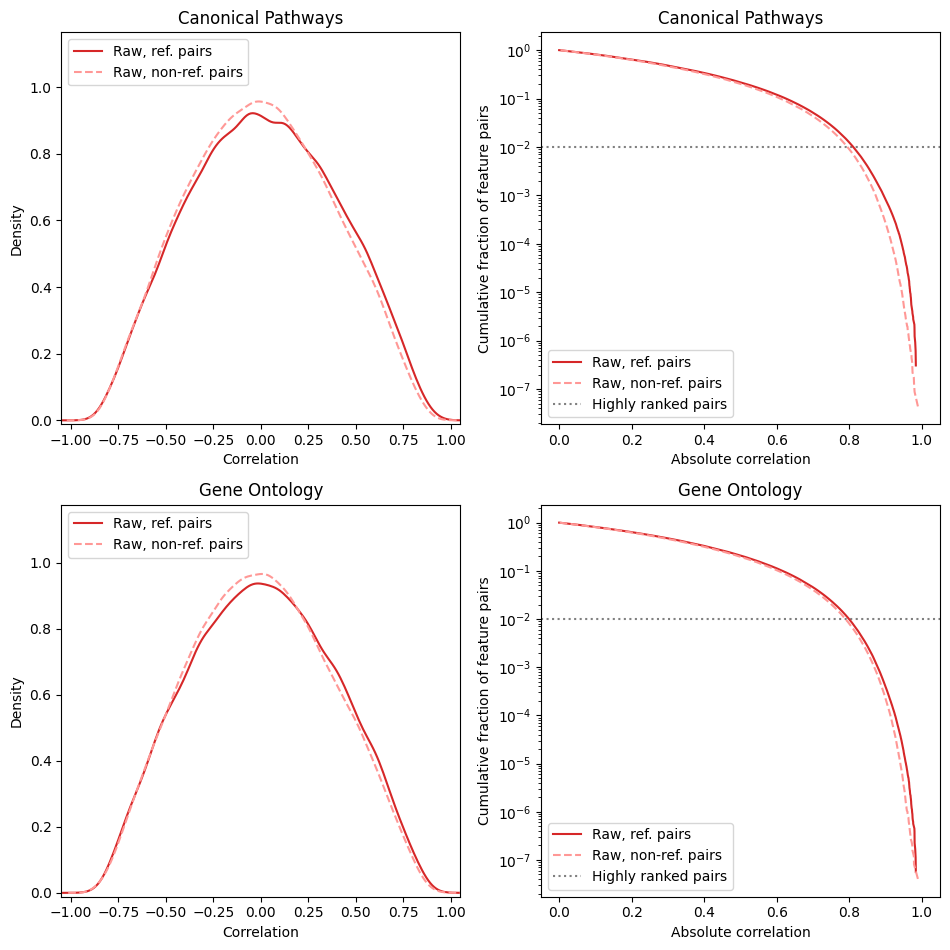

In [14]:
model.make_corr_distr_plot(df_data_train, "corr_distr.before_cleaning.png")

We don't expect any signal from feature pairs with low absolute correlations. Thus, the selected threshold for the number of pairs should correspond to a reasonably high correlation threshold (see the cumulative plots). In the above case, the default 1% of gene pairs correspond to correlation ~0.8, which is a fairly high correlation. Also keep in mind that the cleaning procedure *usually* shrinks many high correlations to zero, so the correlation threshold may significantly drop after confounder cleaning.

To sum up, we recommend aiming at the raw correlation threshold somewhere in the 0.4–0.8 range. If you decided to change the default, don't forget to update the value of `high_corr_frac` in the configuration dict and re-create the `CorrAdjust` instance.

Finally, you can make volcano plots using the raw data to see whether you have any statistically significant features before running time-consuming `fit`.

2025-02-28 20:01:07.473775 | Computing raw correlations for all_samp...


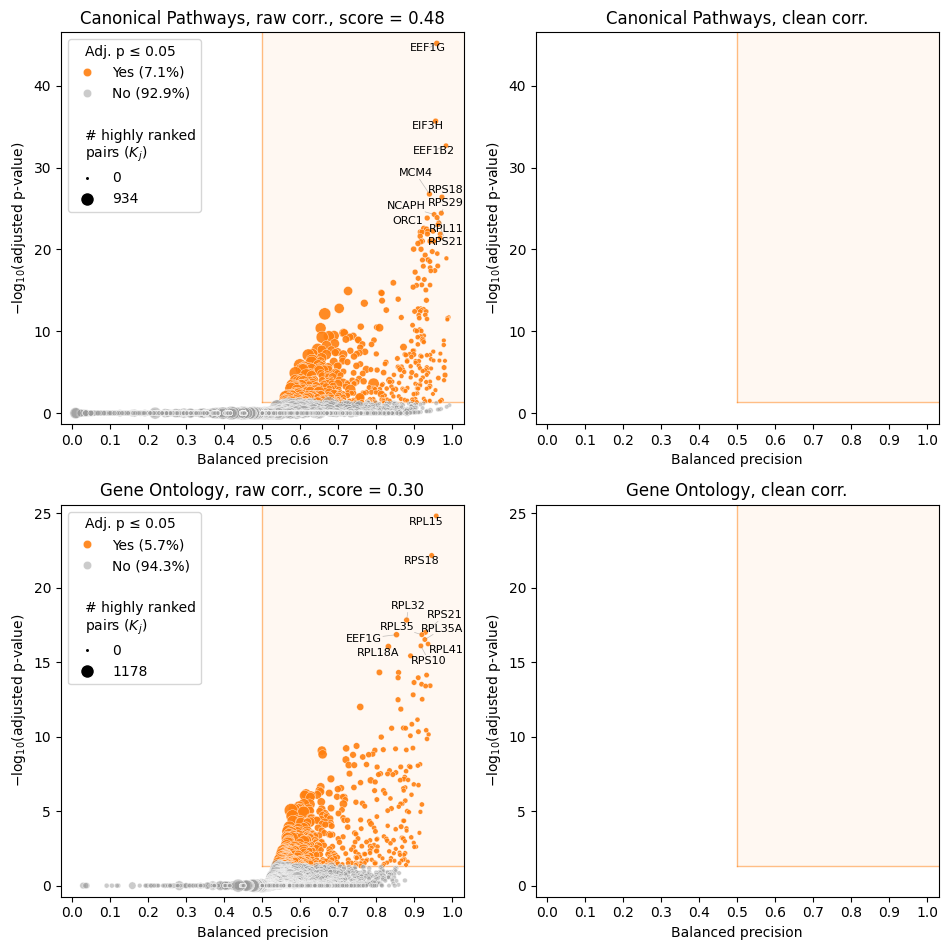

In [15]:
feature_scores_train = model.compute_feature_scores(df_data_train)
model.make_volcano_plot(
    feature_scores_train,
    "volcano.before_cleaning.png",
    annotate_features=10
)